# FCN3 χ=1.0: Modular Theory vs Experiment Scaling

This notebook is refactored into a concise modular workflow.

- `evaluate_case(...)` takes parameters and returns empirical + theoretical `lH1` / `lH3` for both **target** and **perpendicular** modes.
- We run one high-fidelity case at `d=150`.
- We run a logspace sweep `d∈[10,500]` and plot scaling for theory and experiment.

In [21]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch
import numpy as np
from tqdm import tqdm

def second_moment(tensor):
    """Explicitly defined to ensure compatibility with stats calls."""
    return torch.mean(tensor**2)

def compute_h3_projections_hmc(
    model,
    d: int,
    P_total: int = 2_000_000,
    batch_size: int = 100_000,
    device: torch.device = torch.device("cpu"),
    perp_dim: int = 1,
    all_eigs: bool = True,
    hmc_steps: int = 5,
    step_size: float = 0.1
):
    """
    Stream inputs using HMC and compute cubic projections.
    Maintains the exact dictionary interface of the original function.
    """
    assert perp_dim >= 0 and perp_dim < d, f"perp_dim {perp_dim} out of range for d={d}"

    dtype = torch.float32
    ens = model.ens
    n1 = model.n1
    model.to(dtype)
    
    # Accumulators for summed projections over P (He3 and He1)
    proj3_target_sum = torch.zeros(ens, n1, dtype=dtype, device=device)
    proj3_perp_sum = torch.zeros(ens, n1, dtype=dtype, device=device)
    proj1_target_sum = torch.zeros(ens, n1, dtype=dtype, device=device)
    proj1_perp_sum = torch.zeros(ens, n1, dtype=dtype, device=device)

    num_batches = P_total // batch_size
    remainder = P_total % batch_size

    # Initialize the HMC chain state
    X_current = torch.randn(batch_size, d, dtype=dtype, device=device)

    for i in tqdm(range(num_batches + (1 if remainder > 0 else 0)), desc="HMC Batches"):
        bs = batch_size if i < num_batches else remainder
        if bs == 0:
            break
            
        # --- HMC Sampling Logic ---
        # 1. Prepare for Leapfrog
        X = X_current[:bs].clone().detach().requires_grad_(True)
        r = torch.randn_like(X) # Momentum
        initial_r = r.clone()
        
        # 2. Leapfrog Integrator for Gaussian Potential U = 0.5 * ||x||^2
        r = r - 0.5 * step_size * X.data # Half step
        for _ in range(hmc_steps):
            with torch.no_grad():
                X = X + step_size * r # Position step
            r = r - step_size * X.data # Momentum step
        r = r + 0.5 * step_size * X.data # Final half step
        
        # 3. Metropolis-Hastings Accept/Reject
        current_U = 0.5 * torch.sum(X_current[:bs]**2, dim=1)
        current_K = 0.5 * torch.sum(initial_r**2, dim=1)
        proposed_U = 0.5 * torch.sum(X**2, dim=1)
        proposed_K = 0.5 * torch.sum(r**2, dim=1)
        
        accept_prob = torch.exp((current_U + current_K) - (proposed_U + proposed_K))
        accept = torch.rand_like(accept_prob) < accept_prob
        
        X_batch = torch.where(accept.unsqueeze(1), X, X_current[:bs])
        X_current[:bs] = X_batch.detach()
        # --------------------------

        with torch.no_grad():
            x0 = X_batch[:, 0]
            x_perp = X_batch[:, perp_dim]
            
            # Cubic Hermite features
            phi3_target = (x0**3 - 3.0 * x0) / np.sqrt(6.0)
            phi3_perp = (x_perp**3 - 3.0 * x_perp) / np.sqrt(6.0)
            # Linear features (He1)
            phi1_target = x0
            phi1_perp = x_perp
            
            # Hidden preactivations
            a1 = model.h1_preactivation(X_batch)

            # Accumulate projections (sum over samples)
            proj3_target_sum += torch.einsum('pqn,p->qn', a1, phi3_target) / P_total
            proj3_perp_sum += torch.einsum('pqn,p->qn', a1, phi3_perp) / P_total
            proj1_target_sum += torch.einsum('pqn,p->qn', a1, phi1_target) / P_total
            proj1_perp_sum += torch.einsum('pqn,p->qn', a1, phi1_perp) / P_total
            
            torch.cuda.empty_cache()
    
    # Final Projections
    proj3_target = proj3_target_sum
    proj3_perp = proj3_perp_sum
    proj1_target = proj1_target_sum
    proj1_perp = proj1_perp_sum

    # Eigenvalue calculation
    eig_target1 = proj1_target.var().cpu().numpy().flatten()
    eig_perp1 = proj1_perp.var().cpu().numpy().flatten()
    eig_target3 = proj3_target.var().cpu().numpy().flatten()
    eig_perp3 = proj3_perp.var().cpu().numpy().flatten()
    
    if all_eigs:
        eigenvalues = np.concatenate([
            eig_target1, np.tile(eig_perp1, d - 1), 
            eig_target3, np.tile(eig_perp3, d**3 - 1)
        ]).flatten()
    else:
        eigenvalues = np.array([])

    # Internal stats helper to ensure all keys like 'second_moment' exist
    def get_stats(proj_tensor):
        p_mean = proj_tensor.mean(dim=1) # per ensemble mean
        m_val = torch.mean(proj_tensor).item()
        v_val = proj_tensor.var().item()
        return {
            "mean": float(m_val),
            "std": float(torch.std(proj_tensor).item()),
            "var": float(v_val),
            "second_moment": float(v_val + (m_val**2)),
            "ens_mean": float(p_mean.mean().item()),
            "ens_std": float(p_mean.std().item()),
            "ens_sem": float(p_mean.std().item() / (ens**0.5))
        }

    stats = {
        "ens": int(ens),
        "n1": int(n1),
        "d": int(d),
        "P_total": int(P_total),
        "batch_size": int(batch_size),
        "perp_dim": int(perp_dim),
        "h3": {
            "target": get_stats(proj3_target),
            "perp": get_stats(proj3_perp),
        },
        "h1": {
            "target": get_stats(proj1_target),
            "perp": get_stats(proj1_perp),
        },
        "h3_eigenvalues": eigenvalues.tolist(),
        "h3_target_eigenvalues": eig_target3.tolist(),
        "h3_perp_eigenvalues": eig_perp3.tolist(),
    }
    return stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import json
repo_root = Path('/home/akiva/FCNX-Ensembling')
milestone_dir = repo_root / 'milestones' / 'activation_generic_erf_mf_scaling_convergence'
lib_dir = repo_root / 'lib'

if str(lib_dir) not in sys.path:
    sys.path.insert(0, str(lib_dir))
if str(milestone_dir) not in sys.path:
    sys.path.insert(0, str(milestone_dir))

from FCN3Network import FCN3NetworkActivationGeneric
from compute_h3_projections_fcn3 import compute_h3_projections_streaming, compute_theory_with_julia

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


def _extract_lh(block, mode):
    if mode == 'target':
        lH1 = block.get('lH1T', block.get('lH1', np.nan))
        lH3 = block.get('lH3T', block.get('lH3', np.nan))
    else:
        lH1 = block.get('lH1P', block.get('lH1', np.nan))
        lH3 = block.get('lH3P', block.get('lH3', np.nan))
    return float(lH1), float(lH3)


def  evaluate_case(
    d,
    n1=1600,
    n2=1600,
    P=1105,
    ens=1,
    chi=1.0,
    kappa=0.1,
    epsilon=0.03 * (6 ** 0.5),
    P_total=2_000_000,
    batch_size=100_000,
    perp_dim=1,
    seed=0,
    use_target_mode=True,
):
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = FCN3NetworkActivationGeneric(
        d,
        n1,
        n2,
        P,
        ens=ens,
        activation='erf',
        weight_initialization_variance=(1.0 / d, 1.0 / n1, 1.0 / n2),
        device=device,
    ).to(device)
    model.eval()

    stats = compute_h3_projections_hmc(
        model=model,
        d=d,
        P_total=P_total,
        batch_size=batch_size,
        device=device,
        perp_dim=perp_dim,
    )

    theory = compute_theory_with_julia(
        d=d,
        n1=n1,
        P=P,
        chi=chi,
        kappa=kappa,
        epsilon=epsilon,
    )

    # Always expose BOTH target and perpendicular theory channels
    t_target = theory.get('target', {})
    t_perp = theory.get('perpendicular', theory.get('perp', {}))
    t_lH1_target, t_lH3_target = _extract_lh(t_target, mode='target')
    t_lH1_perp, t_lH3_perp = _extract_lh(t_perp, mode='perp')

    e_lH1_target = float(stats['h1']['target']['second_moment'])
    e_lH3_target = float(stats['h3']['target']['second_moment'])
    e_lH1_perp = float(stats['h1']['perp']['second_moment'])
    e_lH3_perp = float(stats['h3']['perp']['second_moment'])

    empirical = {
        'target': {'lH1': e_lH1_target, 'lH3': e_lH3_target},
        'perp': {'lH1': e_lH1_perp, 'lH3': e_lH3_perp},
        'lH1': e_lH1_target,
        'lH3': e_lH3_target,
    }
    theoretical = {
        'target': {'lH1': t_lH1_target, 'lH3': t_lH3_target},
        'perp': {'lH1': t_lH1_perp, 'lH3': t_lH3_perp},
        'lH1': t_lH1_target,
        'lH3': t_lH3_target,
    }

    selected_mode = 'target' if use_target_mode else 'perp'

    return {
        'params': {
            'd': d,
            'n1': n1,
            'n2': n2,
            'P': P,
            'ens': ens,
            'chi': chi,
            'kappa': kappa,
            'epsilon': epsilon,
            'P_total': P_total,
            'batch_size': batch_size,
            'perp_dim': perp_dim,
        },
        'empirical': empirical,
        'theoretical': theoretical,
        'selected_mode': selected_mode,
        'selected': {
            'empirical': empirical[selected_mode],
            'theoretical': theoretical[selected_mode],
        },
        'raw': {
            'stats': stats,
            'theory': theory,
        },
    }

Using device: cuda:0


In [31]:
single['raw']['theory']['perpendicular']['lH3P']

1.3972450422333756e-07

In [32]:
# Single high-fidelity evaluation at d=150
single = evaluate_case(
    d=150,
    chi=1.0,
    kappa=0.1,
    epsilon=0.03 * (6 ** 0.5),
    P_total=500_000_000,
    batch_size=100_000,
    perp_dim=1,
)


HMC Batches:   0%|          | 0/5000 [00:00<?, ?it/s]

HMC Batches: 100%|██████████| 5000/5000 [08:25<00:00,  9.88it/s]
/tmp/ipykernel_482877/2719020058.py:136: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "ens_std": float(p_mean.std().item()),
/tmp/ipykernel_482877/2719020058.py:137: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "ens_sem": float(p_mean.std().item() / (ens**0.5))


In [33]:

print('Single-case results (d=150):')
print('  empirical  lH1 =', f"{single['empirical']['lH1']:.6e}")
print('  theoretical lH1 =', f"{single['raw']['theory']['perpendicular']['lH1P']:.6e}")
print('  empirical  lH3 =', f"{single['empirical']['lH3']:.6e}")
print('  theoretical lH3 =', f"{single['raw']['theory']['perpendicular']['lH3P']:.6e}")

r1 = single['empirical']['lH1'] / (single['raw']['theory']['perpendicular']['lH1P'] + 1e-12)
r3 = single['empirical']['lH3'] / (single['raw']['theory']['perpendicular']['lH3P'] + 1e-12)
print('  ratio lH1 (emp/theory) =', f'{r1:.6f}')
print('  ratio lH3 (emp/theory) =', f'{r3:.6f}')

Single-case results (d=150):
  empirical  lH1 = 2.686621e-03
  theoretical lH1 = 2.829421e-03
  empirical  lH3 = 1.385570e-07
  theoretical lH3 = 1.397245e-07
  ratio lH1 (emp/theory) = 0.949530
  ratio lH3 (emp/theory) = 0.991637


In [3]:
# Save to file for easy reloading and plotting later
import json 

In [17]:
single['raw']['stats']

{'ens': 1,
 'n1': 1600,
 'd': 150,
 'P_total': 1000,
 'batch_size': 100,
 'perp_dim': 1,
 'h3': {'target': {'mean': -0.0001292889501200989,
   'std': 0.021058157086372375,
   'var': 0.00044344598427414894,
   'second_moment': 0.0004431855631992221,
   'ens_mean': -0.0001292889501200989,
   'ens_std': nan,
   'ens_sem': nan},
  'perp': {'mean': -0.0003307701554149389,
   'std': 0.01846628077328205,
   'var': 0.0003410035278648138,
   'second_moment': 0.00034089983091689646,
   'ens_mean': -0.0003307701554149389,
   'ens_std': nan,
   'ens_sem': nan}},
 'h1': {'target': {'mean': 0.0002119333075825125,
   'std': 0.057216186076402664,
   'var': 0.003273691749200225,
   'second_moment': 0.00327169056981802,
   'ens_mean': 0.0002119333075825125,
   'ens_std': nan,
   'ens_sem': nan},
  'perp': {'mean': -0.00012366034206934273,
   'std': 0.05202594771981239,
   'var': 0.0027066990733146667,
   'second_moment': 0.0027050229255110025,
   'ens_mean': -0.00012366034206934273,
   'ens_std': nan,
 

In [ ]:

with open(milestone_dir / 'fcn3_chi1_projection_theory_results.json', 'w') as f:
    json.dump(single, f, indent=4)

In [6]:
# Logspace sweep in d and scaling plot for lH1/lH3 (theory vs experiment)
# Use a lighter P_total for sweep runtime; adjust upward if desired.
d_values = np.unique(np.round(np.logspace(np.log10(10), np.log10(500), 10)).astype(int))
P_total_sweep = 20_000_000

In [18]:


sweep = []
for d_i in d_values:
    print(f'Running d={d_i} ...')
    res = evaluate_case(
        d=int(d_i),
        chi=1.0,
        kappa=0.1,
        epsilon=0.03 * (6 ** 0.5),
        P_total=P_total_sweep,
        batch_size=100_000,
        perp_dim=1,
    )
    sweep.append(res)
# Save sweep results to file for easy reloading and plotting later
# Remove the large eigenvalue arrays from the raw stats to reduce file size
# They are located in stats 
#     stats = {...  "h3_eigenvalues": eigenvalues.tolist(),
        # "h3_target_eigenvalues": eig_target3.tolist(),
        # "h3_perp_eigenvalues": eig_perp3.tolist(), ...}

# Remove the large eigenvalue arrays from the raw stats to reduce file size
for r in sweep:
    if 'h3_eigenvalues' in r['raw']['stats']:
        del r['raw']['stats']['h3_eigenvalues']


with open(milestone_dir / 'fcn3_chi1_projection_theory_sweep_results.json', 'w') as f:
    json.dump(sweep, f, indent=4)

D = np.array([r['params']['d'] for r in sweep], dtype=float)
exp_h1 = np.array([r['empirical']['lH1'] for r in sweep], dtype=float)
exp_h3 = np.array([r['empirical']['lH3'] for r in sweep], dtype=float)
the_h1 = np.array([r['raw']['theory']['perpendicular']['lH1P'] for r in sweep], dtype=float)
the_h3 = np.array([r['raw']['theory']['perpendicular']['lH3P'] for r in sweep], dtype=float)



Running d=10 ...


Batches:   0%|          | 0/200 [00:00<?, ?it/s]

Batches: 100%|██████████| 200/200 [00:17<00:00, 11.63it/s]
/home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/compute_h3_projections_fcn3.py:287: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  ens_std = float(torch.std(tensor_per_ens).item())


Running d=15 ...


Batches: 100%|██████████| 200/200 [00:17<00:00, 11.65it/s]
/home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/compute_h3_projections_fcn3.py:287: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  ens_std = float(torch.std(tensor_per_ens).item())


Running d=24 ...


Batches: 100%|██████████| 200/200 [00:17<00:00, 11.64it/s]
/home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/compute_h3_projections_fcn3.py:287: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  ens_std = float(torch.std(tensor_per_ens).item())


Running d=37 ...


Batches: 100%|██████████| 200/200 [00:17<00:00, 11.64it/s]
/home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/compute_h3_projections_fcn3.py:287: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  ens_std = float(torch.std(tensor_per_ens).item())


Running d=57 ...


Batches: 100%|██████████| 200/200 [00:17<00:00, 11.61it/s]
/home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/compute_h3_projections_fcn3.py:287: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  ens_std = float(torch.std(tensor_per_ens).item())


Running d=88 ...


Batches: 100%|██████████| 200/200 [00:17<00:00, 11.60it/s]
/home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/compute_h3_projections_fcn3.py:287: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  ens_std = float(torch.std(tensor_per_ens).item())


Running d=136 ...


Batches: 100%|██████████| 200/200 [00:17<00:00, 11.57it/s]
/home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/compute_h3_projections_fcn3.py:287: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  ens_std = float(torch.std(tensor_per_ens).item())


Running d=210 ...


Batches: 100%|██████████| 200/200 [00:19<00:00, 10.07it/s]
/home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/compute_h3_projections_fcn3.py:287: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  ens_std = float(torch.std(tensor_per_ens).item())


Running d=324 ...


Batches: 100%|██████████| 200/200 [00:19<00:00, 10.04it/s]
/home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/compute_h3_projections_fcn3.py:287: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  ens_std = float(torch.std(tensor_per_ens).item())


Running d=500 ...


Batches: 100%|██████████| 200/200 [00:20<00:00,  9.92it/s]
/home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/compute_h3_projections_fcn3.py:287: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  ens_std = float(torch.std(tensor_per_ens).item())


In [4]:
# Reload old sweep results from file (if needed)
with open(milestone_dir / 'fcn3_chi1_projection_theory_sweep_results.json', 'r') as f:
    sweep = json.load(f)

In [12]:
d_values = np.unique(np.round(np.logspace(np.log10(400), np.log10(1500), 10)).astype(int))
with open(milestone_dir / 'fcn3_chi1_projection_theory_sweep_results.json', 'r') as f:
    sweep = json.load(f)

for d_i in d_values:
    print(f'Running d={d_i} ...')
    if d_i < 400:  # Skip smaller d values that are already in the sweep results to save time
        continue
    res = evaluate_case(
        d=int(d_i),
        chi=1.0,
        kappa=0.1,
        epsilon=0.03 * (6 ** 0.5),
        P_total=50000000,
        batch_size=1000,
        perp_dim=1,
    )
    if 'h3_eigenvalues' in res['raw']['stats']:
        del res['raw']['stats']['h3_eigenvalues']
    sweep[str(d_i)] = res
    # Resave after each new point is added but do not overwrite 
    with open(milestone_dir / 'fcn3_chi1_projection_theory_sweep_results.json', 'w') as f:
        json.dump(sweep, f, indent=4)

Running d=400 ...


HMC Batches:   0%|          | 0/50000 [00:00<?, ?it/s]

HMC Batches: 100%|██████████| 50000/50000 [01:56<00:00, 429.10it/s]
/tmp/ipykernel_468086/2719020058.py:136: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "ens_std": float(p_mean.std().item()),
/tmp/ipykernel_468086/2719020058.py:137: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "ens_sem": float(p_mean.std().item() / (ens**0.5))


Running d=463 ...


HMC Batches: 100%|██████████| 50000/50000 [01:57<00:00, 425.81it/s]
/tmp/ipykernel_468086/2719020058.py:136: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "ens_std": float(p_mean.std().item()),
/tmp/ipykernel_468086/2719020058.py:137: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "ens_sem": float(p_mean.std().item() / (ens**0.5))


Running d=537 ...


HMC Batches: 100%|██████████| 50000/50000 [01:59<00:00, 419.28it/s]
/tmp/ipykernel_468086/2719020058.py:136: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "ens_std": float(p_mean.std().item()),
/tmp/ipykernel_468086/2719020058.py:137: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "ens_sem": float(p_mean.std().item() / (ens**0.5))


Running d=621 ...


HMC Batches: 100%|██████████| 50000/50000 [10:39<00:00, 78.22it/s]
/tmp/ipykernel_468086/2719020058.py:136: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "ens_std": float(p_mean.std().item()),
/tmp/ipykernel_468086/2719020058.py:137: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "ens_sem": float(p_mean.std().item() / (ens**0.5))


Running d=720 ...


HMC Batches: 100%|██████████| 50000/50000 [10:39<00:00, 78.15it/s]
/tmp/ipykernel_468086/2719020058.py:136: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "ens_std": float(p_mean.std().item()),
/tmp/ipykernel_468086/2719020058.py:137: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "ens_sem": float(p_mean.std().item() / (ens**0.5))


Running d=834 ...


HMC Batches: 100%|██████████| 50000/50000 [02:14<00:00, 372.11it/s]
/tmp/ipykernel_468086/2719020058.py:136: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "ens_std": float(p_mean.std().item()),
/tmp/ipykernel_468086/2719020058.py:137: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "ens_sem": float(p_mean.std().item() / (ens**0.5))


Running d=965 ...


HMC Batches: 100%|██████████| 50000/50000 [02:30<00:00, 333.00it/s]
/tmp/ipykernel_468086/2719020058.py:136: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "ens_std": float(p_mean.std().item()),
/tmp/ipykernel_468086/2719020058.py:137: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "ens_sem": float(p_mean.std().item() / (ens**0.5))


Running d=1118 ...


HMC Batches: 100%|██████████| 50000/50000 [10:42<00:00, 77.84it/s]
/tmp/ipykernel_468086/2719020058.py:136: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "ens_std": float(p_mean.std().item()),
/tmp/ipykernel_468086/2719020058.py:137: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "ens_sem": float(p_mean.std().item() / (ens**0.5))


: 

In [1]:
# Load the sweep results from file
# recall milestone_dir = repo_root / 'milestones' / 'activation_generic_erf_mf_scaling_convergence'
# load Path module

import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
repo_root = Path('/home/akiva/FCNX-Ensembling')
milestone_dir = repo_root / 'milestones' / 'activation_generic_erf_mf_scaling_convergence'
with open(milestone_dir / 'fcn3_chi1_projection_theory_sweep_results.json', 'r') as f:
    sweep = json.load(f)

In [2]:
sweep.keys()

dict_keys(['20', '300', '31', '48', '74', '114', '176', '271', '419', '647', '1000', '400', '463', '537', '621', '720', '834', '965'])

In [3]:
sweep.keys()

dict_keys(['20', '300', '31', '48', '74', '114', '176', '271', '419', '647', '1000', '400', '463', '537', '621', '720', '834', '965'])

In [4]:
D = np.array([r['params']['d'] for r in sweep.values()], dtype=float)
exp_h1 = np.array([r['empirical']['lH1'] for r in sweep.values()], dtype=float)
exp_h3 = np.array([r['empirical']['lH3'] for r in sweep.values()], dtype=float)
the_h1 = np.array([r['raw']['theory']['perpendicular']['lH1P'] for r in sweep.values()], dtype=float)
the_h3 = np.array([r['raw']['theory']['perpendicular']['lH3P'] for r in sweep.values()], dtype=float)

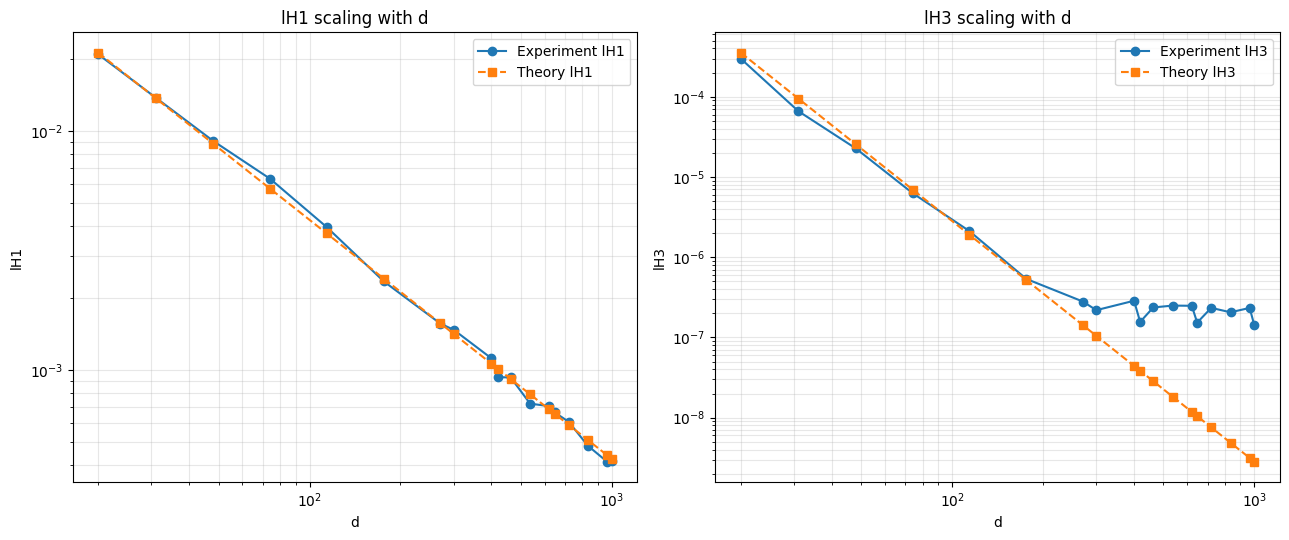

Saved plot to: /home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/chi1_lH_scaling_vs_d.png


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5.5))
D_sorted = np.argsort(D)

ax = axes[0]
ax.loglog(D[D_sorted], exp_h1[D_sorted], 'o-', label='Experiment lH1')
ax.loglog(D[D_sorted], the_h1[D_sorted], 's--', label='Theory lH1')
ax.set_xlabel('d')
ax.set_ylabel('lH1')
ax.set_title('lH1 scaling with d')
ax.grid(True, which='both', alpha=0.3)
ax.legend()

ax = axes[1]
ax.loglog(D[D_sorted], 6*exp_h3[D_sorted], 'o-', label='Experiment lH3')
ax.loglog(D[D_sorted], the_h3[D_sorted], 's--', label='Theory lH3')
ax.set_xlabel('d')
ax.set_ylabel('lH3')
ax.set_title('lH3 scaling with d')
ax.grid(True, which='both', alpha=0.3)
ax.legend()

plt.tight_layout()
plot_path = milestone_dir / 'chi1_lH_scaling_vs_d.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()
print('Saved plot to:', plot_path)